In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.lines import Line2D
import math
import itertools
import statsmodels.api as sm
import os, glob
import datetime
import seaborn as sns

In [2]:
def growth_rate_to_weekly_perc(a):
    return 100*(math.exp(7*a)-1)

def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a)
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b

In [3]:
def fit_inferred_exponential(y):
    _x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    _y = [y_val if (y_val and y_val>0) else np.nan for y_val in y]
    log_y = np.log(_y)
    _xsm = sm.add_constant(_x)
    results = sm.OLS(log_y,_xsm, missing="drop").fit()
    b,a = results.params
    r = results.rsquared
    return a,b # exp growth rate, "initial" value

def add_inferred_exponential(ax, y):
    x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    a,b = fit_inferred_exponential(y)
    y_pred = [math.exp(a*i+b) for i in x]    
    ax.plot(x, y_pred, color="blue", label="fitted to exponential growth")

In [4]:
msoas = {
  "Blackburn with Darwen" : "E06000008",  
  "Bolton" : "E08000001",
  "Hounslow" : "E09000018",
  #"North Tyneside" : "E08000022",
  "Kirklees" : "E08000034",
  #"Leicester" : "E06000016"
  "Lambeth" : "E09000022",
  "Kingston upon Thames" : "E09000021",
  "Reigate and Banstead" : "E07000211",
  "Bedford" : "E06000055",
  "Sefton" : "E08000014",
}

dfs = {}

for name, msoa in msoas.items():
    req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&areaCode=%s&metric=newCasesBySpecimenDateRollingSum&format=json" % msoa
    response = get(req, timeout=10)
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
    response = response.json()
    
    df = pd.DataFrame(response['body'])
    df['dateTime'] = pd.to_datetime(df['date'])
    df.sort_values(by=['dateTime'], inplace=True)
    
    dfs[name] = df
    

In [5]:
xls = pd.ExcelFile('COVID-19-weekly-announced-vaccinations-20-May-2021.xlsx')
vax_df = pd.read_excel(xls, 'MSOA')

xls = pd.ExcelFile('SAPE22DT4-mid-2019-msoa-syoa-estimates-unformatted.xlsx')
pop_df = pd.read_excel(xls, 'Mid-2019 Persons')

In [6]:
start_row = 14
msoa_col = 5
vax_col_1 = 7 #12
vax_col_2 = 17
i = start_row
vaxxed = {}
while (True):
    try:
        vaxxed[vax_df.iloc[i, msoa_col]] = np.sum(vax_df.iloc[i, vax_col_1:vax_col_2])
        i += 1
    except:
        break

In [7]:
start_row = 5
msoa_col = 0
pop_col_1 = 7 #+60
pop_col_2 = 150
i = start_row
pop = {}
while (True):
    try:
        pop[pop_df.iloc[i, msoa_col]] = np.sum(pop_df.iloc[i, pop_col_1:pop_col_2])
        i += 1
    except:
        break

In [8]:
def draw_graph(name, df):
    n_prev_days = 6
    x_dates = sorted(list(set(df.date.to_list())))

    title = "MSOAs in %s" % name
    ylabel = "+ve tests by specimen date, weekly totals"
    divider_offset = 7

    regions = sorted(list(df.areaCode.unique()))
    #regions = sorted(regions, key=lambda x: df[df.areaCode==x].newCasesBySpecimenDateRollingSum.to_list()[-1])

    max_g = 0
    min_g = 1
    max_pop = 0
    min_pop = 1e6
    for region in regions:
        g = vaxxed[region]/pop[region]
        max_g = max(g,max_g)
        min_g = min(g,min_g)
        #print(region, g, vaxxed[region], pop[region])
        max_pop = max(pop[region],max_pop)
        min_pop = min(pop[region],min_pop)

    y_dict = {}
    for region in regions:
        y = np.array(df[df.areaCode==region].newCasesBySpecimenDateRollingSum.to_list())
        y_dict[region] = y#np.log(y)   

    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,8))
    fig.suptitle(title)
    x = x_dates[-n_prev_days:]
    for region, y in y_dict.items():
        a = max(0.2, (pop[region] - min_pop) / (max_pop - min_pop) )
        g = vaxxed[region]/pop[region]
        g = (g-min_g)/(max_g-min_g)
        ax1.plot(x, y[-n_prev_days:], label=region, alpha=a, color = (1-g, g, 0))

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel("date")
    ax1.set_ylim(0,160)

    custom_lines = [Line2D([0], [0], color=(0,1,0), lw=4),
                    Line2D([0], [0], color=(1,0,0), lw=4),
                    Line2D([0], [0], color=(1,1,1), lw=4),
                    Line2D([0], [0], color=(1,1,1), lw=4)]

    custom_labels = ['most vaxxed (first doses %d%% on 20/5/21 as %% of 30/6/20 population)' % (100*max_g), 
                     'least vaxxed (first doses %d%% on 20/5/21 as %% of 30/6/20 population)' % (100*min_g), 
                     'age range: all',
                     'alpha ~ population size (smallest: %d, largest %d)' % (min_pop, max_pop)]    
    
    ax1.legend(custom_lines, custom_labels, loc = "upper left")


    today = datetime.datetime.now().strftime("%Y-%m-%d")
    filename = today + " " + title
    plt.show()
    #plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.1)
    print(name)


<Figure size 432x288 with 0 Axes>

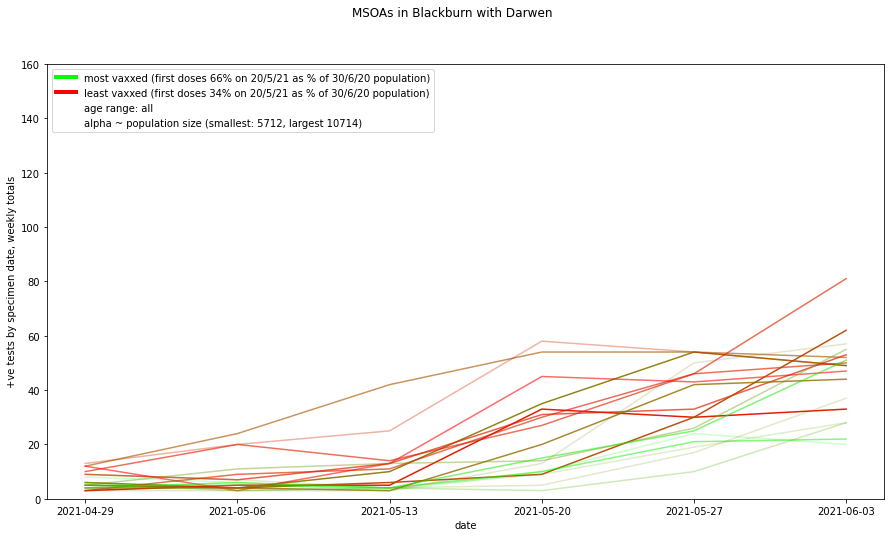

Blackburn with Darwen


<Figure size 432x288 with 0 Axes>

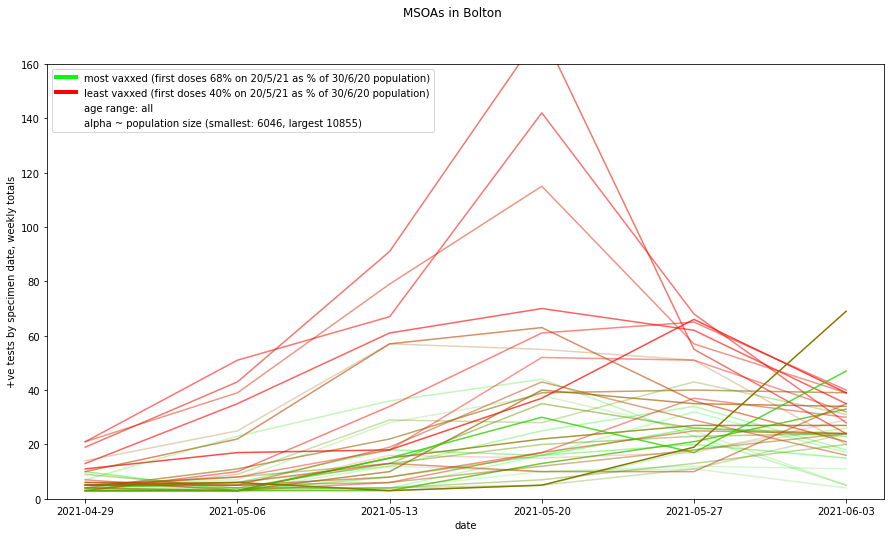

Bolton


<Figure size 432x288 with 0 Axes>

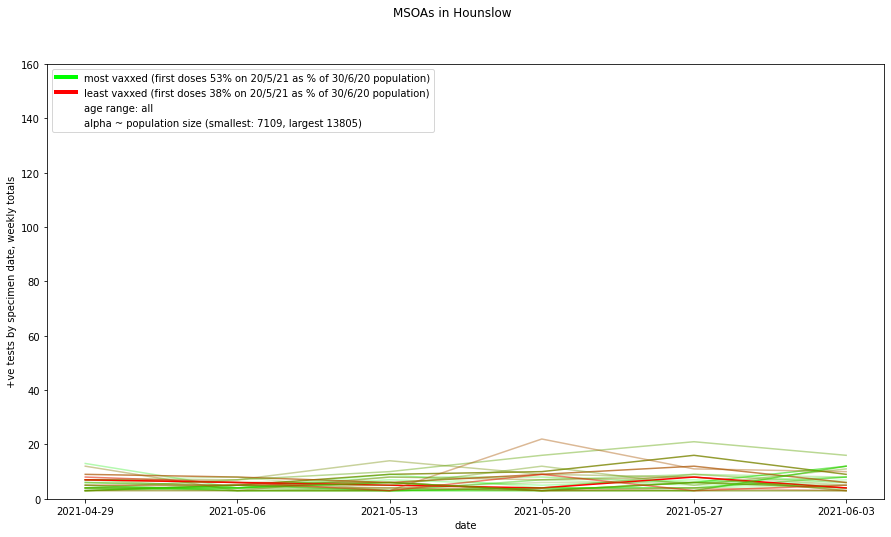

Hounslow


<Figure size 432x288 with 0 Axes>

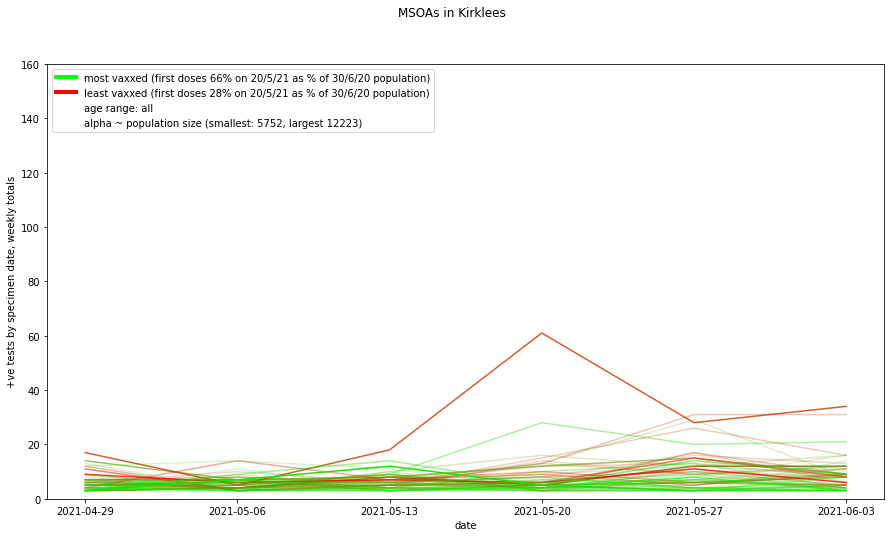

Kirklees


<Figure size 432x288 with 0 Axes>

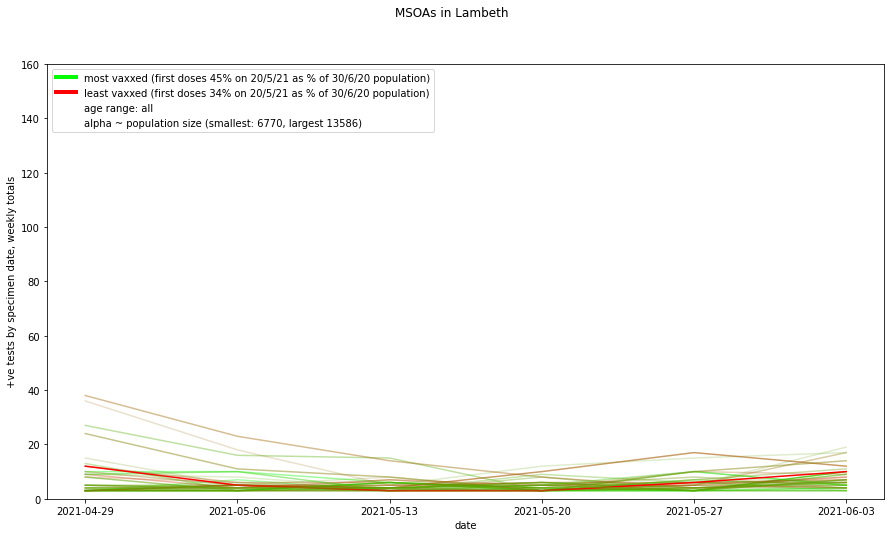

Lambeth


<Figure size 432x288 with 0 Axes>

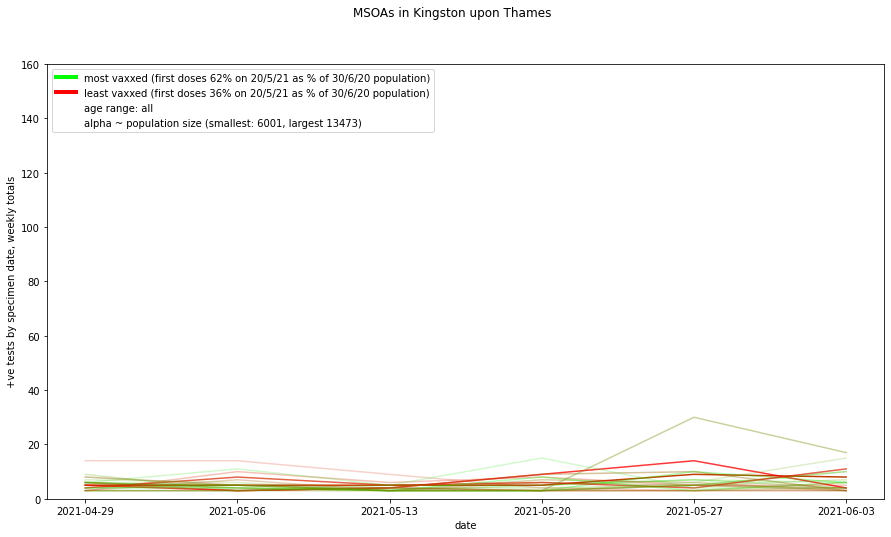

Kingston upon Thames


<Figure size 432x288 with 0 Axes>

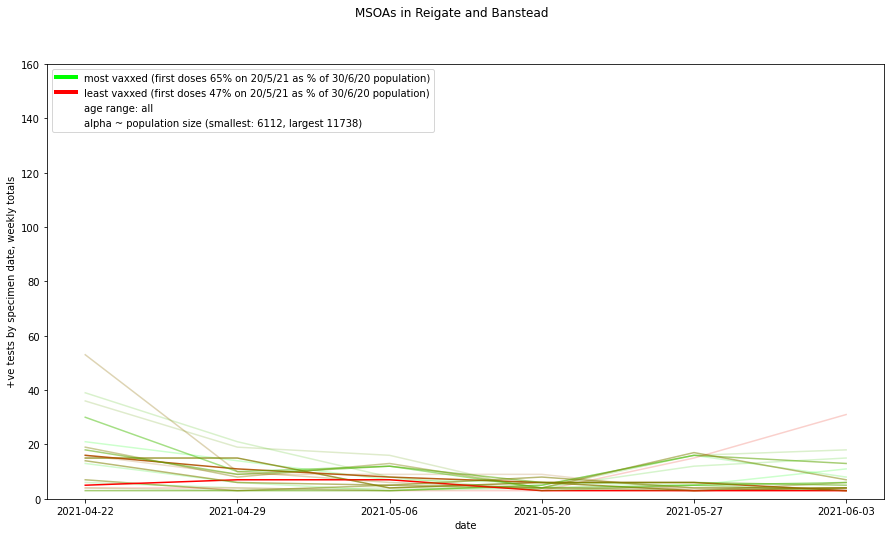

Reigate and Banstead


<Figure size 432x288 with 0 Axes>

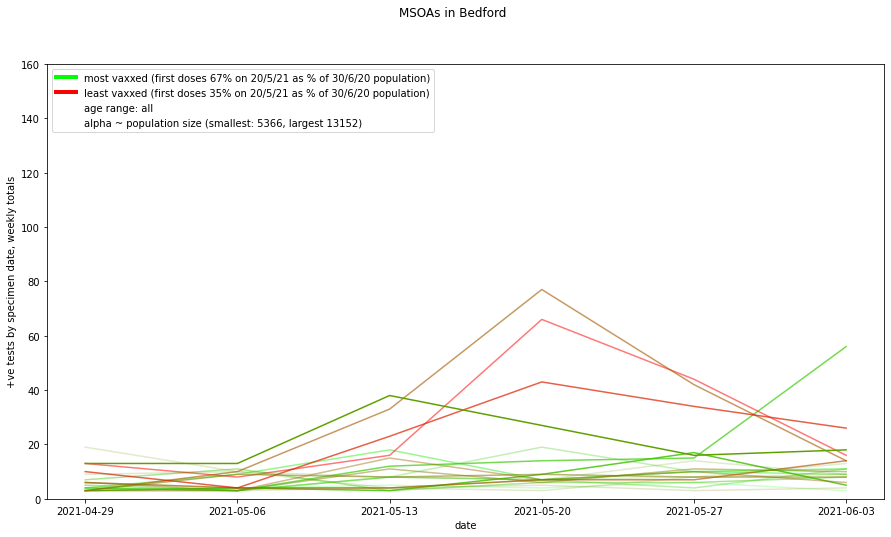

Bedford


<Figure size 432x288 with 0 Axes>

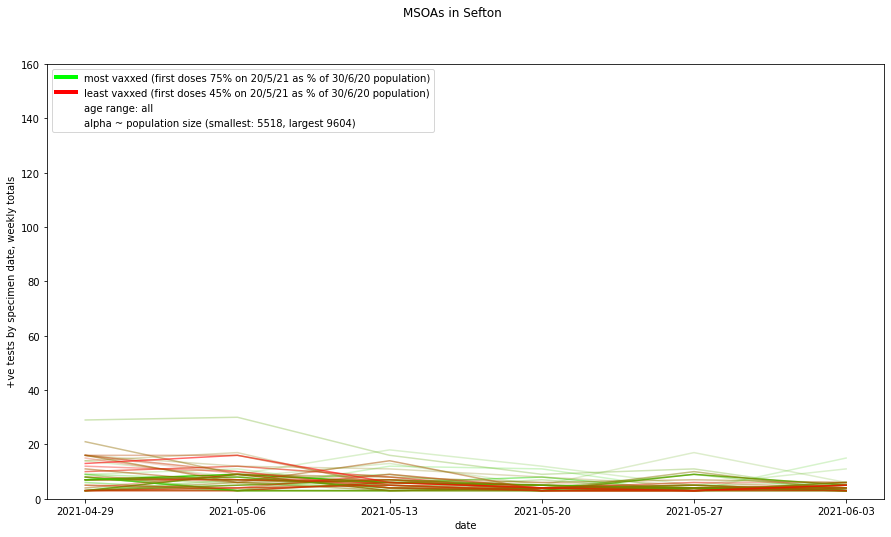

Sefton


In [9]:
for name, msoa in msoas.items():
    draw_graph(name, dfs[name])

In [10]:
import numpy as np
from PIL import Image
import glob

return
 
list_im = glob.glob("*.png")
imgs    = [ Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
 
# save that beautiful picture
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'Trifecta.png' )    
 
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'Trifecta_vertical.png' )

SyntaxError: 'return' outside function (<ipython-input-10-06039a269d66>, line 5)